In [21]:
import os
import sys
import json
import random
from collections import Counter
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.stats import ttest_ind
import numpy as np
from numpy.linalg import norm
from numpy import sqrt
from sklearn.metrics import accuracy_score
from math import pi
import pickle
import matplotlib.pyplot as plt
from packages import data_container
from packages.data_container import Data
from packages.helper import play_trajs, rotate, sp2a, v2sp, psi, beta, d_theta, d_psi, sp2v, dist, min_dist, \
    vector_angle, signed_angle, side, inner, theta, min_sep, traj_speed
from packages.ode_simulator import ODESimulator
# For pickle to load the Data object, which is defined in packages.data_container
sys.modules['data_container'] = data_container

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Fajen_steer1a_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst2_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst1_data_30Hz.pickle'))
with open(file, 'rb') as f:
    data = pickle.load(f)

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst2_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)
%matplotlib qt

### Bai_movObst1

In [ ]:
'''trial lookup'''
i = 167
t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
data.info['rel_dpsi'][167][t1+1]

In [ ]:
'''Counting trials'''
cnt = 0
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
        cnt += 1
cnt

In [23]:
'''effective data length'''
%matplotlib qt
l = []
sim = ODESimulator(data=data, ref=[0,1])
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
#         t0 = data.info['obst_onset'][i]
#         t0 = data.info['decision_onset'][i]
        t0 = data.info['threshold_onset'][i]
        t1 = data.info['obst_out'][i]
        if t0 and t1:
            l.append((t1 - t0) / data.Hz)
#             if t1 - t0 < 2:
#                 print(i, t0, t1)
#                 order = []
#                 for t in range(t0, t1):
#                     xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, a, phi, s, dphi, ds, w0 = sim.compute_var0(i, t)
#                     # When beta and dpsi has the same sign it means pass in front, otherwise it means pass from behind
#                     dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
#                     angle = sim.data.info['obst_angle'][i]
#                     order.append(-dpsi * np.sign(angle))
#                 plt.plot(order)
#                 break
plt.hist(l, bins=40)
# plt.plot(l)

Loading finished


(array([  2.,   7.,  19.,  29.,  44.,  97.,  83., 101., 180., 134., 137.,
        114.,  83.,  98.,  61.,  58.,  23.,  19.,  17.,  11.,   4.,  20.,
          7.,   2.,  11.,   8.,  11.,  10.,   1.,   1.,   5.,   5.,   2.,
          1.,   4.,   5.,   2.,   2.,   2.,   2.]),
 array([1.3       , 1.44583333, 1.59166667, 1.7375    , 1.88333333,
        2.02916667, 2.175     , 2.32083333, 2.46666667, 2.6125    ,
        2.75833333, 2.90416667, 3.05      , 3.19583333, 3.34166667,
        3.4875    , 3.63333333, 3.77916667, 3.925     , 4.07083333,
        4.21666667, 4.3625    , 4.50833333, 4.65416667, 4.8       ,
        4.94583333, 5.09166667, 5.2375    , 5.38333333, 5.52916667,
        5.675     , 5.82083333, 5.96666667, 6.1125    , 6.25833333,
        6.40416667, 6.55      , 6.69583333, 6.84166667, 6.9875    ,
        7.13333333]),
 <a list of 40 Patch objects>)

In [ ]:
'''Animate avoidance data'''
############
subject = 3
trial = 111
############
%matplotlib qt
i = subject * 160 + trial - 1
i = 511
# p_obst = np.array(data.info['p_obst'][i])
td = data.info['decision_onset'][i]
t0 = data.info['obst_onset'][i]
t1 = data.info['obst_out'][i]
p_goal = data.info['p_goal'][i]
p_subj = data.info['p_subj'][i]
p_obst = data.info['p_obst'][i]
trajs = [p_goal, p_obst, p_subj]
ws = [data.info['w_goal'], data.info['w_obst'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' obst_angle: ' + str(data.info['obst_angle'][i]) + ' obst_speed: ' + str(data.info['obst_speed'][i])
print(data.info['subj_id'][i], data.info['trial_id'][i], td, t1)
play_trajs(trajs, ws, data.Hz, title=title, save=False)


In [19]:
set(data.info['obst_speed'])

{0.0, 0.9, 1.0, 1.1, 1.2, 1.3}

### Bai_movObst1: dpsi and order of passing

In [105]:
'''Compute initial passing order (-dpsi * sign(obst_angle)) time series'''
%matplotlib qt
orders = {}
conditions = np.zeros((5, 8))
angle_ins = {-157.5: 0, -135: 1, -112.5: 2, -90: 3, 90: 4, 112.5: 5, 135: 6, 157.5: 7}
speed_ins = {0.9: 0, 1: 1, 1.1: 2, 1.2: 3, 1.3: 4}
for i in range(len(sim.data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] != 0 and abs(data.info['obst_angle'][i]) != 180:
        rel_dpsi = data.info['rel_dpsi'][i]
        subj = data.info['subj_id'][i]
        angle = data.info['obst_angle'][i]
        speed = data.info['obst_speed'][i]
        t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
        if subj not in orders:
            orders[subj] = {'correct': [], 'incorrect': []}
        t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
        if np.sign(rel_dpsi[t0]) == data.info['pass_order'][i]:
            orders[subj]['correct'].append(rel_dpsi)
        else:
            orders[subj]['incorrect'].append(rel_dpsi)
            conditions[speed_ins[speed], angle_ins[angle]] += 1

In [104]:
'''Plot conditions of incorrect trial'''
# Scatter plot
# x = []
# y = []
# z = []
# for angle in angle_ins.values():
#     for speed in speed_ins.values():
#         x.append(angle)
#         y.append(speed)
#         z.append(conditions[angle, speed])
#         for _ in range(int(conditions[angle, speed])):
#             plt.scatter(angle + random.uniform(-0.25, 0.25), speed + random.uniform(-0.25, 0.25))

# plt.xticks(range(-1, 9), [""] + list(angle_ins.keys()) + [""])
# plt.yticks(range(-1, 5), [""] + list(speed_ins.keys()) + [""])

# Heatmap
plt.imshow(conditions, cmap='plasma')
for i in range(conditions.shape[0]):
    for j in range(conditions.shape[1]):
        text = plt.text(j, i, str(conditions[i, j]),
                       ha="center", va="center", color="w")
plt.xticks(range(-1, 9), [""] + list(angle_ins.keys()) + [""])
plt.yticks(range(-1, 5), [""] + list(speed_ins.keys()) + [""])
plt.xlabel("angle")
plt.ylabel("speed")

# 3D bar graph
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.bar3d(x,y,0,0.5,0.5,z)
# ax.set_xticks(angle_ins.keys())
# ax.set_yticks(speed_ins.keys())

Text(0, 0.5, 'speed')

In [14]:
'''Check initial dpsi and subject passing choice, plot dpsi of matching and non-matching trials'''
%matplotlib qt
subjects = set(data.info['subj_id'])
print(subjects)
side_pred = []
side_true = []
dpsi_match = []
dpsi_not = []
for i in range(len(sim.data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] != 0 and abs(data.info['obst_angle'][i]) != 180:
        # When angle and dpsi has the opposite sign it means pass in front, otherwise it means pass from behind
        t0 = data.info['obst_onset'][i]
        rel_dpsi = data.info['rel_dpsi'][i][t0]
        side_pred.append(1 if rel_dpsi > 0 else -1)
        side_true.append(sim.data.info['pass_order'][i])
        if side_pred[-1] == side_true[-1]:
            dpsi_match.append(rel_dpsi)
        else:
            dpsi_not.append(rel_dpsi)
print('passing order matching rate ', accuracy_score(side_true, side_pred))
thres = 0.02
print(f'{np.mean(np.absolute(np.array(dpsi_not)) < thres) * 100}% mis-matching trials have an intial dpsi < {thres}')
plt.scatter(np.random.uniform(size=len(dpsi_match)), dpsi_match, label='matching trials')
plt.scatter(np.random.uniform(size=len(dpsi_not)), dpsi_not, label='mis-matching trials')
plt.ylabel('dpsi')
plt.xlabel('arbitrary')
plt.legend()


{0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13}
passing order matching rate  0.7447257383966245
97.52066115702479% mis-matching trials have an intial dpsi < 0.02


In [16]:
'''Correct order ratio'''
correct = incorrect = 0
for order in orders.values():
    correct += len(order['correct'])
    incorrect += len(order['incorrect'])
print(correct, incorrect, correct / (correct + incorrect))

1059 363 0.7447257383966245


In [7]:
'''Plot passing order (dpsi * sign(obst_angle)) time series'''
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
        t0 = data.info['obst_onset'][i]
        t1 = data.info['obst_out'][i]
        rel_dpsi = data.info['rel_dpsi'][i]
        # Plot minimum |dpsi|
        mi = np.argmin(np.absolute(rel_dpsi[t0:t1]))
        plt.scatter(mi, rel_dpsi[mi + t0], c='k')
        # Plot maximum |dpsi| from time 0 to t_minimum|dpsi|
        ma = np.argmax(np.absolute(rel_dpsi[t0:t0 + mi + 1]))
        plt.scatter(ma, rel_dpsi[ma + t0], c='r')
        if np.sign(rel_dpsi[t0]) == data.info['pass_order'][i]:
            plt.plot(range(len(rel_dpsi[t0:t1])), rel_dpsi[t0:t1], linewidth=0.1, alpha=0.5, color='g')
        else:
            plt.plot(range(len(rel_dpsi[t0:t1])), rel_dpsi[t0:t1], linewidth=0.1, alpha=0.5, color='r')
plt.xlabel("Time since obst appear", fontsize=20)
plt.ylabel("dpsi (rad/s), positive means front", fontsize=20)

Text(0, 0.5, 'dpsi (rad/s), positive means front')

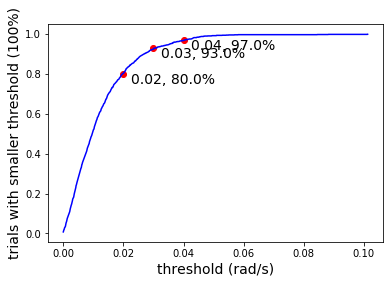

In [3]:
'''Plot x: threshold, y: % trials that have smaller threshold'''
thress = []
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
        t0 = data.info['obst_onset'][i]
        t1 = data.info['obst_out'][i]
        rel_dpsi = data.info['rel_dpsi'][i]
        # Find minimum |dpsi|
        mi = np.argmin(np.absolute(rel_dpsi[t0:t1]))
        # Find maximum |dpsi| from time 0 to t_minimum|dpsi|
        thres = max(np.absolute(rel_dpsi[t0:t0 + mi + 1]))
        thress.append(thres)
# evaluate the histogram
values, base = np.histogram(thress, bins=1000)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative / len(thress), c='blue')
plt.xlabel("threshold (rad/s)", fontsize=14)
plt.ylabel("trials with smaller threshold (100%)", fontsize=14)


# Mark point of interest
for v in [0.02, 0.03, 0.04]:
    x = np.argmin(np.absolute(base - v))
    y = round(cumulative[x] / len(thress), 2)
    x = round(base[x], 2)
    plt.scatter(x, y, c='r')
    plt.annotate(f"{x}, {round(y * 100, 2)}%", (x+0.0025, y-0.05), fontsize=14)

In [ ]:
'''Plot average time series by subject'''
length = 267
subjs = {}
t = np.linspace(0, 266/90, 267)
for subj in set(data.info['subj_id']):
    n = 0
    vals = np.zeros(length)
    for i in range(len(data.trajs)):
        if i in data.dump or data.info['obst_speed'][i] == 0:
            continue
        subj_id = data.info['subj_id'][i]
        ground = data.info['ground'][i]
        ipd = data.info['ipd'][i]
        dsize = data.info['dsize'][i]
        dpsi = abs(data.info['dpsi'][i][:length])
        if subj_id == subj:
            n += 1
            vals += np.array(dpsi)
    vals /= n
    plt.plot(t, vals, label='subj ' + str(subj))
plt.xlabel('time (s)')
plt.ylabel('dpsi (rad/s)')
plt.legend()

In [ ]:
'''Plot average time series by one condition'''
length = 267
n = 0
vals = np.zeros(length)
t = np.linspace(0, 266/90, 267)
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    subj_id = data.info['subj_id'][i]
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    dpsi = abs(data.info['dpsi'][i][:length])
    if dsize == 0:
        n += 1
        vals += np.array(dpsi)
vals /= n
plt.plot(t, vals, label='constant size')
plt.xlabel('time (s)')
plt.ylabel('dpsi (rad/s)')
plt.legend()

In [ ]:
'''Find the min length of simulation window'''
min_t = float('inf')
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    dpsi = data.info['dpsi'][i]
    min_t = min(min_t, len(dpsi))
min_t

In [ ]:
'''Count pass order by condition'''
#########
angle = 157.5
speed = 1.1
#########
fpass = 0
total = 0
for i in range(len(data.trajs)):
    if abs(data.info['obst_angle'][i]) != angle or data.info['obst_speed'][i] != speed:
        continue
    if data.info['pass_order'][i] == 1:
        fpass += 1
    total += 1
print(fpass, total)
print(fpass / total)

In [ ]:
'''Minimum Passing Distance'''
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Signed predicted minimum passing distance (SMPD)')
ax.set_ylabel('SMPD (m)')
ax.set_xlabel('normalized time (%)')
ax.set_ylim((-2, 2))
for i in range(len(data.trajs)):
    t0 = data.info['stimuli_onset'][i]
    t1 = data.info['stimuli_out'][i]
    p0 = data.info['p_subj'][i][t0:t1]
    p1 = data.info['p_obst'][i][t0:t1]
    v0 = data.info['v_subj'][i][t0:t1]
    v1 = data.info['v_obst'][i][t0:t1]
    t = np.linspace(0, 100, len(p0))
    smpd = []
    for _p0, _p1, _v0, _v1 in zip(p0, p1, v0, v1):        
        smpd.append(min_sep(_p0, _p1, _v0, _v1)[0])
    ax.plot(t, smpd, 'k', linewidth=0.1, alpha=0.5)
    
    

In [ ]:
'''Plot acceleration angle and magnitude'''
%matplotlib qt
trials = range(400,401)
subject = 1
con_angle = [90, -90]
con_speed = []
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
for i in trials:
    angle = data.info['obst_angle'][i]
    speed = data.info['obst_speed'][i]
    subj_id = data.info['subj_id'][i]
    if i in data.dump:
        continue
#     if angle not in con_angle or subj_id != subject:
#         continue
    t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
    p0, p1, a0 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1]), np.array(data.info['a_subj'][i][t0:t1])
    angles = signed_angle(p1 - p0, a0)
    ax0.scatter(range(len(angles)), angles, s=1)
    ax1.plot(norm(a0, axis=-1))
    print(data.info['subj_id'][i], data.info['trial_id'][i])

In [ ]:
'''Plot dpsi dtheta by time'''
%matplotlib qt
subjects = range(16)
n = len(data.trajs)
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
fig2 = plt.figure()
ax2 = fig2.add_subplot()
for i in range(2,3):
    if (data.info['subj_id'][i] in subjects and
        i not in data.dump and
        data.info['obst_speed'][i] != 0 and
        abs(data.info['obst_angle'][i]) != 180):
        t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
        p0, p1 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1])
        v0, v1 = np.array(data.info['v_subj'][i][t0:t1]), np.array(data.info['v_obst'][i])
        a0 = np.array(data.info['a_subj'][i][t0:t1])
        a0 = norm(a0, axis=-1)
        v1 = np.tile(v1, (len(v0), 1))
        dpsis = np.absolute(d_psi(p0, p1, v0, v1))
        dthetas = d_theta(p0, p1, v0, v1, w=0.1)
        thetas = theta(p0, p1, w=0.1)
        ratio = dthetas/thetas
        ax0.plot(a0)
        c1, c2 = 0, 0.2
        ax1.plot((ratio+c1)/(dpsis+c2))
        ax2.scatter(ratio[60:80], a0[60:80], s=1)
#         ax2.scatter(range(len(dpsis)), dthetas/dpsis, s=1)

In [ ]:
'''Plot data by condition'''
#####################
subject = 3
con_ang = [112.5]
con_spd = [1.1]
con_ipd = [0, 0.07]
# con_ang = set(data.info['obst_angle'])
# con_spd = set(data.info['obst_speed'])
#####################
%matplotlib qt
plt.figure()
n = 0
for i in range(len(data.trajs)):
    obst_speed = data.info['obst_speed'][i]
    obst_angle = data.info['obst_angle'][i]
    ipd = data.info['ipd'][i]
    subj_id = data.info['subj_id'][i]
    if subject != -1 and subj_id != subject:
        continue
    if not (obst_speed in con_spd and abs(obst_angle) in con_ang and ipd in con_ipd):
        continue
    subj = data.info['p_subj'][i]
    obst = np.array(data.info['p_obst'][i])
    n += 1
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if obst_angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    if ipd == 0:
        plt.plot(subj[:, 0], subj[:, 1], color='r')
    else:
        plt.plot(subj[:, 0], subj[:, 1], color='b')
    plt.plot(obst[:, 0], obst[:, 1])
ax = plt.gca()
# ax.set_aspect('equal')
ax.set_title('subj ' + str(subject) + ' angle: ' + str(con_ang[0]) + ' speed: ' + str(con_spd[0]))
print(n)

In [ ]:
'''Plot data by subject'''
#####################
subject = 13
#####################
%matplotlib qt
fig = plt.figure()
fig.suptitle('Subject ' + str(subject))
axes = {}
obst_angle = [90, 112.5, 135, 157.5, 180]
obst_speed = [0.9, 1.0, 1.1, 1.2, 1.3]
i_plot = 1
for angle in obst_angle:
    for speed in obst_speed:
        axes[(angle, speed)] = fig.add_subplot(5, 5, i_plot)
        axes[(angle, speed)].set_xlim(-3, 3)
        axes[(angle, speed)].set_ylim(-7, 5)
        axes[(angle, speed)].set_title(str(angle) + '° ' + str(speed) + 'm/s')
        axes[(angle, speed)].set_aspect('equal')
        i_plot += 1
for i in range(len(data.trajs)):
    speed = data.info['obst_speed'][i]
    angle = data.info['obst_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject or speed == 0:
        continue
    subj = np.array(data.info['p_subj'][i])
    obst = np.array(data.info['p_obst'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    axes[(abs(angle), speed)].plot(subj[:, 0], subj[:, 1])
    axes[(abs(angle), speed)].plot(obst[:, 0], obst[:, 1])

In [ ]:
'''Check trial length from match_onset to stimuli_out'''
match_onsets = []
lens = []
for i in range(len(data.trajs)):
    if i not in data.dump:
        p0 = data.info['p_subj'][i]
        p1 = data.info['p_obst'][i]
        v0 = data.info['v_subj'][i]
        v1 = data.info['v_obst'][i]
        stimuli_out = data.info['stimuli_out'][i]
        stimuli_onset = data.info['stimuli_onset'][i]
        match_onset = data.info['match_onset'][i]
        dpsis = d_psi(p0, p1, v0, v1)
        if stimuli_out - match_onset <= 30:
            plt.plot(dpsis)
            plt.plot(dpsis[match_onset:stimuli_out])
            print(i)
        match_onsets.append(data.info['match_onset'][i])
        lens.append(data.info['stimuli_out'][i] - data.info['match_onset'][i])
# plt.hist(match_onsets)
# plt.figure()
# plt.hist(lens)

### Bai_movObst2

In [ ]:
'''Passing distance, pass order by condition Bai_movObst2'''
%matplotlib qt
#########
grounds = [1, 0]
ipds = [0.07, 0]
dsizes = [-0.1, 0, 0.1]
#########
pd1 = []
pd2 = []
po1 = []
po2 = []
dp1 = []
dp2 = []
ps1 = []
ps2 = []
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    t0 = data.info['obst_onset'][i]
    t1 = data.info['obst_out'][i]
    p0 = data.info['p_subj'][i][t1]
    p1 = data.info['p_obst'][i][t1]
    ps = norm(data.info['v_subj'][i][t0])
    pass_order = data.info['pass_order'][i]
    j = 0
#     for j in range(t0, t1):
#         x, y = data.info['p_subj'][i][j]
#         xo, yo = data.info['p_obst'][i][j]
#         dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
#         if dpsi > 0.05:
#             break
    if pass_order == -1:
        pass_order = 0
    d = dist(p0, p1)
    if dsize == 0.1:
        pd1.append(d)
        po1.append(pass_order)
        dp1.append(j)
        ps1.append(ps)
    elif dsize == -0.1:
        pd2.append(d)
        po2.append(pass_order)
        dp2.append(j)
        ps2.append(ps)

var1, var2 = pd1, pd2
print(np.mean(var1), np.mean(var2))
print(ttest_ind(var1, var2))
plt.boxplot([var1,var2])


In [ ]:
'''Match rate by threshold by condition, Bai_movObst2'''
sim = ODESimulator(data=data, ref=[0,1])
thress = np.linspace(0, 0.1, 11)
match_rates = []
match_rates_ipd1 = []
match_rates_ipd0 = []
match_rates_ground1 = []
match_rates_ground0 = []
match_rates_dsize1 = []
match_rates_dsize0 = []
i_ipd1 = []
i_ipd0 = []
i_ground1 = []
i_ground0 = []
i_dsize1 = []
i_dsize0 = []
t0s = {}
for ii, thres in enumerate(thress):
    print(f'thres = {thres}')
    side_pred = []
    side_true = []
    for i in range(len(sim.data.trajs)):
        if i in sim.data.dump or sim.data.info['obst_speed'][i] == 0:
            continue
        t0 = t0s.get(i, sim.data.info['obst_onset'][i])
        t1 = sim.data.info['obst_out'][i]
        ipd = sim.data.info['ipd'][i]
        ground = sim.data.info['ground'][i]
        dsize = sim.data.info['dsize'][i]
        for j in range(t0, t1):
            xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, a, phi, s, dphi, ds, w0 = sim.compute_var0(i, j)
            dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
            if j == t1 - 1:
                print('reached t1 before meeting the threshold')
            if abs(dpsi) > thres:
                t0s[i] = j
                break
        angle = sim.data.info['obst_angle'][i]
        side_pred.append(1 if angle * dpsi < 0 else -1)
        side_true.append(sim.data.info['pass_order'][i])
        if ii == 0:
            i_ipd1.append(True if ipd==0.07 else False)
            i_ipd0.append(True if ipd==0 else False)
            i_ground1.append(True if ground==1 else False)
            i_ground0.append(True if ground==0 else False)
            i_dsize1.append(True if dsize==0.1 else False)
            i_dsize0.append(True if dsize==-0.1 else False)
    if ii == 0:
        i_ipd1 = np.array(i_ipd1)
        i_ipd0 = np.array(i_ipd0)
        i_ground1 = np.array(i_ground1)
        i_ground0 = np.array(i_ground0)
        i_dsize1 = np.array(i_dsize1)
        i_dsize0 = np.array(i_dsize0)
    side_pred = np.array(side_pred)
    side_true = np.array(side_true)
    match_rates.append(accuracy_score(side_true, side_pred))
    match_rates_ipd1.append(accuracy_score(side_true[i_ipd1], side_pred[i_ipd1]))
    match_rates_ipd0.append(accuracy_score(side_true[i_ipd0], side_pred[i_ipd0]))
    match_rates_ground1.append(accuracy_score(side_true[i_ground1], side_pred[i_ground1]))
    match_rates_ground0.append(accuracy_score(side_true[i_ground0], side_pred[i_ground0]))
    match_rates_dsize1.append(accuracy_score(side_true[i_dsize1], side_pred[i_dsize1]))
    match_rates_dsize0.append(accuracy_score(side_true[i_dsize0], side_pred[i_dsize0]))
    
plt.plot(thress, match_rates, label='All trials')
plt.plot(thress, match_rates_ipd1, label='disparity')
plt.plot(thress, match_rates_ipd0, label='no disparity')
plt.plot(thress, match_rates_ground1, label='ground')
plt.plot(thress, match_rates_ground0, label='no ground')
plt.plot(thress, match_rates_dsize1, label='grow')
plt.plot(thress, match_rates_dsize0, label='shrink')
plt.ylabel('Percentage')
plt.xlabel('dpsi threshold')
plt.legend()


In [ ]:
'''Average time series of dpsi by subj and condition, Bai_movObst2'''
dpsi = {}
length = 267
t = np.linspace(0, 266/90, 267)
subjs = set(data.info['subj_id'])
subjs.add(0)
for subj in subjs:
    dpsi[subj] = {}
    for ground in [1, 0]:
        dpsi[subj][ground] = {}
        for ipd in [0.07, 0]:
            dpsi[subj][ground][ipd] = {}
            for dsize in [-0.1, 0, 0.1]:
                dpsi[subj][ground][ipd][dsize] = {}
                dpsi[subj][ground][ipd][dsize]['vals'] = np.zeros(length)
                dpsi[subj][ground][ipd][dsize]['n'] = 0

for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    subj = data.info['subj_id'][i]
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    vals = np.array(abs(data.info['dpsi'][i][:length]))
    dpsi[subj][ground][ipd][dsize]['vals'] += vals
    dpsi[subj][ground][ipd][dsize]['n'] += 1
    dpsi[0][ground][ipd][dsize]['vals'] += vals
    dpsi[0][ground][ipd][dsize]['n'] += 1

plt.plot()
ground_con = {1:'ground', 0:'no ground'}
ipd_con = {0.07:'disparity', 0:'no disparity'}
dsize_con = {0.1:'grow', -0.1:'shrink', 0:'constant'}
for ground in [1, 0]:
    for ipd in [0.07, 0]:
        for dsize in [-0.1, 0, 0.1]:
            plt.plot(t, dpsi[0][ground][ipd][dsize]['vals'] / dpsi[0][ground][ipd][dsize]['n'], 
                     label=f'{ground_con[ground]}, {ipd_con[ipd]}, {dsize_con[dsize]}')
plt.legend()


### Bai_movObst1b (approach model)

In [ ]:
'''Animate approach data'''
i = 528
t0 = data.info['stimuli_onset'][i]
t1 = data.info['stimuli_out'][i]
print(t0, t1)
p_goal = data.info['p_goal'][i][t0:t1]
p_subj = data.info['p_subj'][i][t0:t1]
trajs = [p_goal, p_subj]
ws = [data.info['w_goal'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' goal_d0: ' + str(data.info['goal_d0'][i]) + ' goal_angle: ' + str(data.info['goal_angle'][i]) + ' leader_s0: ' + str(data.info['leader_s0'][i])
print(data.info['subj_id'][i], data.info['trial_id'][i])
play_trajs(trajs, ws, data.Hz, title=title, save=False)

In [ ]:
'''Plot speed'''
for i in range(len(data.trajs)):
    if data.info['stimuli_out'][i] and data.info['stimuli_onset'][i] and data.info['leader_s0'] and i not in data.dump:
        t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
        v_subj = data.info['v_subj'][i]
        s_subj = norm(v_subj, axis=1)
        plt.plot(s_subj[t0:t1])

In [ ]:
'''Check trial length'''
%matplotlib qt
a = []
for i in range(len(data.trajs)):
    if data.info['stimuli_out'][i] and data.info['stimuli_onset'][i] and data.info['leader_s0'] and i not in data.dump:
        l = data.info['stimuli_out'][i] - data.info['stimuli_onset'][i]
        a.append(l)
        if (l < 100 or l > 1000) and i not in data.dump:
            print(i, l)
plt.plot(a)

In [ ]:
'''Check trajectories'''
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['leader_s0']:
        if data.info['goal_d0'][i] == 8:
            plt.plot(data.info['p_subj'][i][:, 0], data.info['p_subj'][i][:, 1])

In [ ]:
set(data.info['goal_d0'])

In [ ]:

'''Plot data by condition'''
#####################
subject = 0
s0 = [1.4]
d0 = [8]
angle = [15]
s0 = set(data2.info['goal_s0'])
d0 = set(data2.info['goal_d0'])
angle = set(data2.info['goal_angle'])
#####################
%matplotlib qt
plt.figure()
for i in range(len(data2.trajs)):
    goal_s0 = data2.info['goal_s0'][i]
    goal_d0 = data2.info['goal_d0'][i]
    goal_angle = data2.info['goal_angle'][i]
    subj_id = data2.info['subj_id'][i]
    if subj_id != subject:
        continue
    if not (goal_s0 in s0 and goal_d0 in d0 and abs(goal_angle) in angle):
        continue
    subj = np.array(data2.info['p_subj'][i])
    goal = np.array(data2.info['p_goal'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) + pi / 2)
#     if goal_angle < 0:
#         subj[:, 0] *= -1
#         goal[:, 0] *= -1
    plt.plot(subj[:, 0], subj[:, 1])
    print(subj)
    plt.plot(goal[:, 0], goal[:, 1])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title(f'subj {str(subject)} angle: {str(angle)} s0: {str(s0)} d0: {str(d0)}')

In [ ]:
'''Cohen experiments'''
file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst_exp1_data.pickle'))
with open(file, 'rb') as f:
    cohen1 = pickle.load(f)

In [ ]:
cohen1.info['pass_order']
# data.info['pass_order']

In [ ]:
''' Check optimal parameters from training results '''
bests = {} 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', ''))
filenames = [os.path.join(path, name) for name in os.listdir(path) if name[-3:] == 'txt']
filenames = [filenames[1]]
# b1s = []
# k1s = []
errs = []
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        for i, line in enumerate(f):
            if i == 1:
                subj_id = line[-5:-2]
            if i >= 11:
                try:
                    err = str(line).split("\\t")[-4][:10]
                    if err[0] == '0':
                        err = float(err)
                        if err < e_min:
                            e_min = err
                            best = str(line).replace("\\", "")
                except:
                    pass
                # Find all parameters that have small error
#                 if subj_id == 0 and float(err) < 0.16:
#                     model = str(line).split("\\t")[1].split("}")[1][1:] + '}'
#                     model = model.replace('\'', '\"')
#                     d = json.loads(model)
#                     b1s.append(d['b1'])
#                     k1s.append(d['k1'])
#                     errs.append(float(err))
    bests[subj_id] = best
for i, best in bests.items():
    print('\n')
    print(i, best)

In [ ]:
''' Check optimal parameters from cross validation'''
bests = {} 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', 'Bai_movObst1b_individual_fajen_approach1&2', 'fajen_approach2'))
filenames = [os.path.join(path, name) for name in os.listdir(path) if name[-3:] == 'txt']
errs = []
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        if filename[-6] == '_':
            subj_id = int(filename[-5])
        else:
            subj_id = int(filename[-6:-4])
        for i, line in enumerate(f):
            if i > 10:
                try:
                    err = str(line).split("\\t")[2]
                    if err[0] == '0':
                        err = float(err)
                        if err < e_min:
                            e_min = err
                            best = str(line).replace("\\", "")
                except:
                    pass

    bests[subj_id] = best
for i, err in bests.items():
    print('\n')
    print(i, err)

In [ ]:
bests